In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import torch
from pygsp import graphs
from scipy import sparse

from qubic.lib.Qscene import QubicScene
from qubic.lib.Instrument.Qinstrument import QubicMultibandInstrument, compute_freq
from qubic.lib.Instrument.Qacquisition import QubicInstrumentType
from qubic.lib.Qsamplings import equ2gal, get_pointing
from qubic.lib.Qdictionary import qubicDict
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel

In [2]:
%matplotlib inline

In [3]:
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d = qubicDict()
d.read_from_file(dictfilename)

center = equ2gal(d['RA_center'], d['DEC_center'])

In [4]:
d['nf_recon'] = 4
d['nf_sub'] = 4
d['MultiBand'] = True

d['synthbeam_kmax'] = 1
nf_sub = d['nf_sub']
d['synthbeam_fraction'] = 1

d['use_synthbeam_fits_file'] = False
d['noiseless'] = True
d['photon_noise'] = False
d['npointings'] = 8000
d['instrument_type'] = 'UWB'
nf_recon = d['nf_recon']

#### Zasad cemo koristit qss, posli nadji nacin za dodat prasinu priko CAMB ka u tod_to_comp_masked

#### Krecemo bez prasine i bez suma

In [5]:
d['nside'] = 128

In [6]:
seed = 3
sky_config = {'cmb': seed}
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
sky_map = np.array(d['nf_sub'] * [hp.synfast(cl_cmb, d["nside"], new=True, verbose=False).T])
print(sky_map.shape)

(4, 196608, 3)


In [7]:
p = get_pointing(d)
s = QubicScene(d)
q = QubicMultibandInstrument(d)

In [8]:
_, nus_edge, nus, _, _, _ = compute_freq(d['filter_nu'] / 1e9, d['nf_sub'], d['filter_relative_bandwidth'])
nus

array([135.50540829, 144.29216391, 153.6486907 , 163.61193508])

In [9]:
multiacquisition = QubicInstrumentType(d, nsub = 4, nrec = 4)

Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.


In [10]:
convolution = multiacquisition.subacqs[0].get_convolution_peak_operator()
convolved_sky_map = np.zeros(sky_map.shape)
for i in range(sky_map.shape[0]):
    convolved_map = convolution(sky_map[i])
    convolved_sky_map[i] = convolved_map

In [11]:
TOD_total = np.zeros((nf_recon, 992, 8000))
for i in range(len(multiacquisition.subacqs)):
    TOD_nsub = multiacquisition.subacqs[i].get_operator()(convolved_sky_map[i])
    TOD_total[i] = TOD_nsub

Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.


## Graph structure

In [12]:
def healpix_weightmatrix(nside=16, nest=True, indexes=None, dtype=np.float32):
    """Return an unnormalized weight matrix for a graph using the HEALPIX sampling.

    Parameters
    ----------
    nside : int
        The healpix nside parameter, must be a power of 2, less than 2**30.
    nest : bool, optional
        if True, assume NESTED pixel ordering, otherwise, RING pixel ordering
    indexes : list of int, optional
        List of indexes to use. This allows to build the graph from a part of
        the sphere only. If None, the default, the whole sphere is used.
    dtype : data-type, optional
        The desired data type of the weight matrix.
    """
    if not nest:
        raise NotImplementedError()

    if indexes is None:
        indexes = range(nside**2 * 12)
    npix = len(indexes)  # Number of pixels.
    if npix >= (max(indexes) + 1):
        # If the user input is not consecutive nodes, we need to use a slower
        # method.
        usefast = True
        indexes = range(npix)
    else:
        usefast = False
        indexes = list(indexes)

    # Get the coordinates.
    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.vstack([x, y, z]).transpose()
    coords = np.asarray(coords, dtype=dtype)
    # Get the 7-8 neighbors.
    neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)
    # if use_4:
    #     print('Use 4')
    #     col_index = []
    #     row_index = []
    #     for el,neighbor in zip(indexes,neighbors.T):
    #         x, y, z = hp.pix2vec(nside, [el], nest=nest)
    #         coords_1 = np.vstack([x, y, z]).transpose()
    #         coords_1 = np.array(coords_1)

    #         x, y, z = hp.pix2vec(nside, neighbor, nest=nest)
    #         coords_2 = np.vstack([x, y, z]).transpose()
    #         coords_2 = np.asarray(coords_2)
    #         ind = np.argsort(np.sum((coords_2-coords_1)**2,axis=1),)[:4]
    #         col_index = col_index + neighbor[ind].tolist()
    #         row_index = row_index +[el]*4
    #     col_index = np.array(col_index)
    #     row_index = np.array(row_index)
    # else:
    # Indices of non-zero values in the adjacency matrix.
    col_index = neighbors.T.reshape((npix * 8))
    row_index = np.repeat(indexes, 8)

    # Remove pixels that are out of our indexes of interest (part of sphere).
    if usefast:
        keep = (col_index < npix)
        # Remove fake neighbors (some pixels have less than 8).
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
    else:
        col_index_set = set(indexes)
        keep = [c in col_index_set for c in col_index]
        inverse_map = [np.nan] * (nside**2 * 12)
        for i, index in enumerate(indexes):
            inverse_map[index] = i
        col_index = [inverse_map[el] for el in col_index[keep]]
        row_index = [inverse_map[el] for el in row_index[keep]]

    # Compute Euclidean distances between neighbors.
    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2

    # Compute similarities / edge weights.
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))

    # Similarity proposed by Renata & Pascal, ICCV 2017.
    # weights = 1 / distances

    # Build the sparse matrix.
    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)

    # if use_4:
    #     W = (W+W.T)/2

    return W

In [13]:
def healpix_graph(nside=16,
                  nest=True,
                  lap_type='normalized',
                  indexes=None,
                  use_4=False,
                  dtype=np.float32):

    if indexes is None:
        indexes = range(nside**2 * 12)

    npix = hp.nside2npix(nside)  
    pix = range(npix)
    x, y, z = hp.pix2vec(nside, pix, nest=nest)
    coords = np.vstack([x, y, z]).transpose()[indexes]
    if use_4:
        raise NotImplementedError()
        W = build_matrix_4_neighboors(nside, indexes, nest=nest, dtype=dtype)
    else:
        W = healpix_weightmatrix(
            nside=nside, nest=nest, indexes=indexes, dtype=dtype)
    G = graphs.Graph(
        W,
        lap_type=lap_type,
        coords=coords)
    G.signal = np.zeros(len(indexes), dtype=dtype)
    return G

In [14]:
def get_nside_from_graph(G):
    npix = G.N  
    nside = int(np.sqrt(npix / 12))
    return nside

In [15]:
def get_high_coverage_indexes(cov_map, threshold=0.15):
    maxcov = np.max(cov_map)
    unseen = cov_map < maxcov * threshold
    seen_indexes = np.where(~unseen)[0]  
    return seen_indexes

In [16]:
def get_G_masked_by_cov(G, nside, cov_map, threshold=0.15):
    G_partial_list = []
    if len(cov_map.shape) == 1:
        seen_indexes = get_high_coverage_indexes(cov_map, threshold = treshold)
        G_partial = G.subgraph(seen_indexes)
        G_partial.signal = G.signal[seen_indexes]
        G_partial.det_TOD = G.det_TOD
        print(seen_indexes)
        return G_partial
    
    for row in cov_map:
        seen_indexes = get_high_coverage_indexes(row, nside, threshold=threshold)
        print(seen_indexes)
        G_partial = G.subgraph(seen_indexes)
        G_partial.signal = G.signal[seen_indexes]
        G_partial.det_TOD = G.det_TOD
        
        G_partial_list.append(G_partial)
    
    if cov_map.shape[0] == 1:
        return G_partial_list[0]
    
    return G_partial_list

In [17]:
def get_G_masked_by_cov(G, nside, cov_map, treshold = 0.15): #you have to provide one or the second
    seen_indexes = get_high_coverage_indexes(cov_map, threshold = treshold)
    seen_indexes = hp.ring2nest(nside, seen_indexes)
    G_partial = G.subgraph(seen_indexes)
    G_partial.signal = G.signal[seen_indexes]
    G_partial.coords = G.coords[seen_indexes]
    return G_partial

In [18]:
def plot_sky_3d(graph_map, elev=10, azim=0, edges=False, vmin = None, vmax = None):
    signal = graph_map.signal
    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()
    signal = signal.copy()
    
    
    if vmin is None:
        vmin = signal[signal != -1.6375e+30].min()
    if vmax is None:
        vmax = signal.max()

    graph_map.plotting.update(vertex_size=0.6)
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111, projection='3d')
    
    graph_map.plot_signal(graph_map.signal, show_edges = False, ax=ax, limits = [vmin, vmax])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [19]:
seen_indexes = get_high_coverage_indexes(multiacquisition._get_coverage())
seen_indexes = hp.ring2nest(d['nside'], seen_indexes)

In [20]:
G = healpix_graph(d['nside'], indexes = seen_indexes)

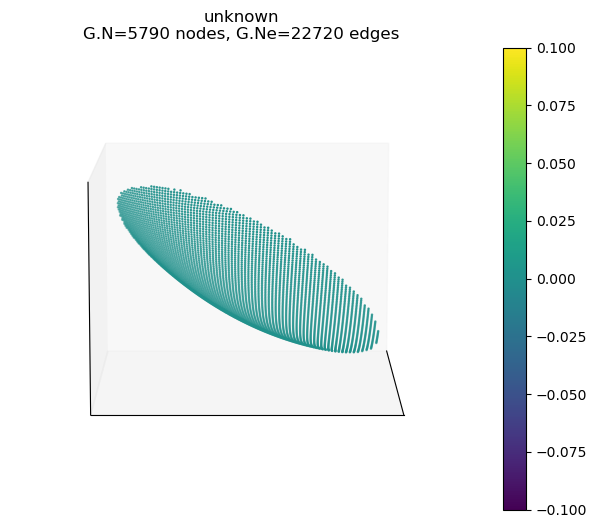

In [21]:
plot_sky_3d(G)

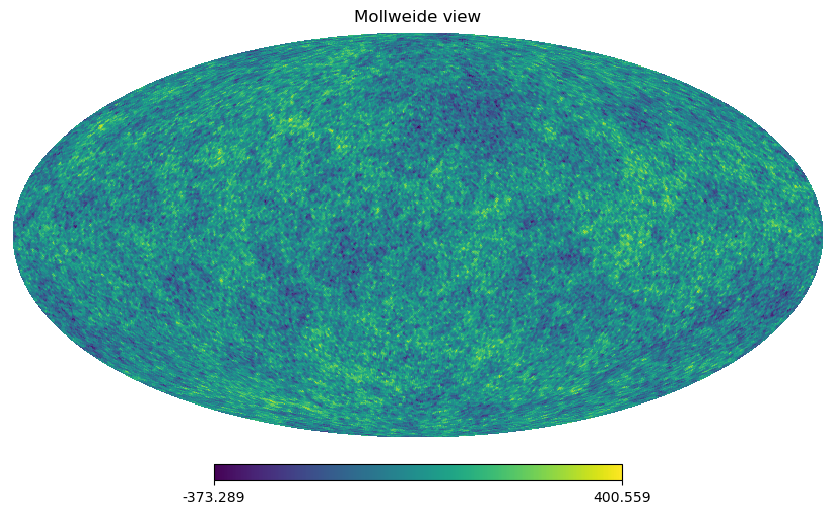

In [22]:
hp.mollview(convolved_sky_map[0,:,0])

In [23]:
input_map_reord = hp.reorder(convolved_sky_map[0,:,0], r2n=True)

G_sky = healpix_graph(nside=d['nside'], nest=True)

G_sky.signal = input_map_reord 

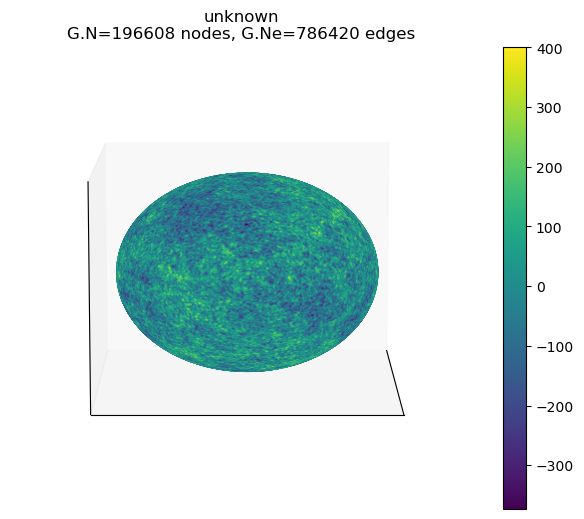

In [24]:
plot_sky_3d(G_sky)

In [25]:
G_sky_partial = G_sky.subgraph(seen_indexes)
G_sky_partial.signal = G_sky.signal[seen_indexes]

In [26]:
#### ode je razlika izmedju stare i nove verzije!!!

In [27]:
G_sky_partial.coords = G_sky.coords[seen_indexes]

In [28]:
G_sky_partial.coords

array([[ 0.53537726, -0.56232432, -0.63020833],
       [ 0.54223753, -0.55571208, -0.63020833],
       [ 0.54901615, -0.54901615, -0.63020833],
       ...,
       [ 0.15375748, -0.13263211, -0.97916667],
       [ 0.16008022, -0.12492783, -0.97916667],
       [ 0.16601731, -0.11692258, -0.97916667]])

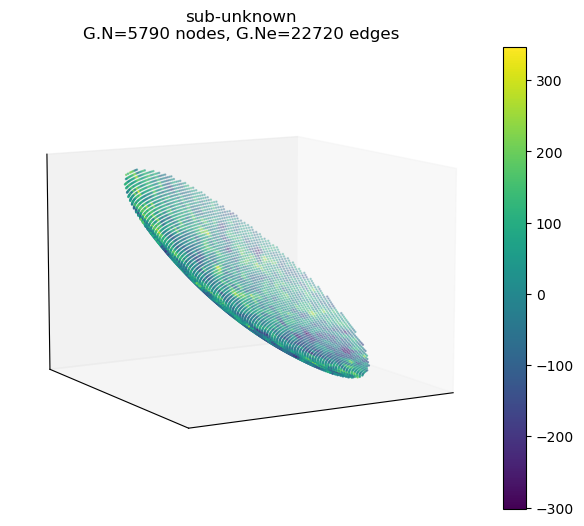

In [ ]:
plot_sky_3d(G_sky_partial)

## Multifeature Graph Structure

In [30]:
def healpix_weightmatrix_multifeature(nside=16, nest=True, indexes=None, dtype=np.float32):
    if not nest:
        raise NotImplementedError()

    if indexes is None:
        indexes = range(nside**2 * 12)
    npix = len(indexes)  # Number of pixels.
    if npix >= (max(indexes) + 1):
        usefast = True
        indexes = range(npix)
    else:
        usefast = False
        indexes = list(indexes)

    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.vstack([x, y, z]).transpose()
    coords = np.asarray(coords, dtype=dtype)
    
    neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)

    col_index = neighbors.T.reshape((npix * 8))
    row_index = np.repeat(indexes, 8)

    if usefast:
        keep = (col_index < npix)
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
    else:
        col_index_set = set(indexes)
        keep = [c in col_index_set for c in col_index]
        inverse_map = [np.nan] * (nside**2 * 12)
        for i, index in enumerate(indexes):
            inverse_map[index] = i
        col_index = [inverse_map[el] for el in col_index[keep]]
        row_index = [inverse_map[el] for el in row_index[keep]]

    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))

    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)

    return W

In [31]:
def healpix_graph_multifeature(nside=16, nest=True, lap_type='normalized', indexes=None, use_4=False, dtype=np.float32):
    if indexes is None:
        indexes = range(nside**2 * 12)

    npix = hp.nside2npix(nside)  
    pix = range(npix)
    x, y, z = hp.pix2vec(nside, pix, nest=nest)
    coords = np.vstack([x, y, z]).transpose()[indexes]
    
    W = healpix_weightmatrix_multifeature(nside=nside, nest=nest, indexes=indexes, dtype=dtype)
    G = graphs.Graph(W, lap_type=lap_type, coords=coords)
    G.signal = np.zeros((len(indexes), 4), dtype=dtype)  # 4 features: I, Q, U, Coverage
    return G

In [32]:
def get_G_masked_by_cov_multifeature(G, nside, cov_map, threshold=0.15):
    seen_indexes = get_high_coverage_indexes(cov_map, threshold=threshold)
    seen_indexes = hp.ring2nest(nside, seen_indexes)
    G_partial = G.subgraph(seen_indexes)
    G_partial.signal = G.signal[seen_indexes]
    G_partial.coords = G.coords[seen_indexes]
    return G_partial

In [33]:
def plot_sky_3d_multifeature(graph_map, feature_index=0, elev=10, azim=0, edges=False, vmin=None, vmax=None):
    signal = graph_map.signal[:, feature_index]  # Select the feature to plot
    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()
    signal = signal.copy()
    
    if vmin is None:
        vmin = signal[signal != -1.6375e+30].min()
    if vmax is None:
        vmax = signal.max()

    graph_map.plotting.update(vertex_size=0.6)
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111, projection='3d')
    
    graph_map.plot_signal(signal, show_edges=edges, ax=ax, limits=[vmin, vmax])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [34]:
G_sky_multifeature = healpix_graph_multifeature(nside=d['nside'], nest=True)

In [35]:
input_map_reord_multifeature = np.zeros((convolved_sky_map.shape))

In [36]:
input_map_reord_multifeature[0,:,0] = hp.reorder(convolved_sky_map[0,:,0], r2n=True)
input_map_reord_multifeature[0,:,1] = hp.reorder(convolved_sky_map[0,:,1], r2n=True)
input_map_reord_multifeature[0,:,2] = hp.reorder(convolved_sky_map[0,:,2], r2n=True)

In [ ]:
G_sky_multifeature.signal = input_map_reord_multifeature[0]

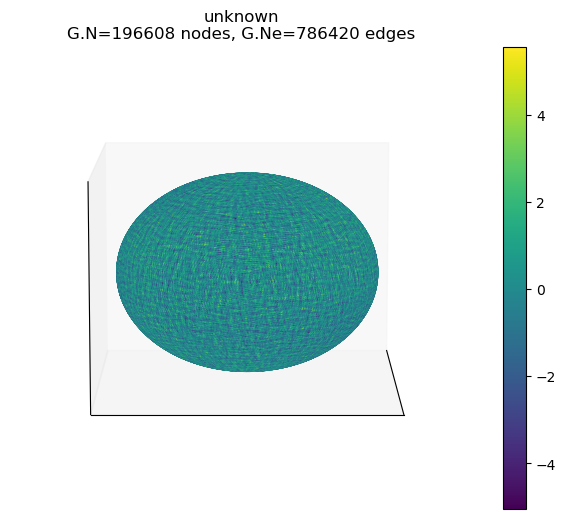

In [42]:
plot_sky_3d_multifeature(G_sky_multifeature, feature_index=1)

In [52]:
from qubic.lib.AnalyticalSolution.operators.forward_ops import ForwardOps

forward_ops = ForwardOps(q[0], multiacquisition, s)

In [53]:
filter = forward_ops.op_filter()

In [54]:
bol_response = forward_ops.op_bolometer_response()